# Importando bibliotecas

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score

# Lendo dados

In [2]:
df = pd.read_csv('../data/processed/sample_df_processed.csv')
df['speed'] = df['speed'].astype('str')
df['feed'] = df['feed'].astype('str')

In [3]:
df.dtypes

vibration_x    float64
vibration_y    float64
vibration_z    float64
machine         object
operation       object
description     object
speed           object
feed            object
duration         int64
result           int64
dtype: object

# Separando dados em treino e teste

In [4]:
X = df.drop(columns=["result"])  
y = df["result"]

# Separando o dataset em treino, validação e teste mantendo a proporção das classes e com uma divisão de 20% para teste e 80% para treino e validação (onde se divide 25% do treino para validação)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

# Pre-processamento dos dados 

In [5]:
# DIVISÃO ENTRE COLUNAS CATEGORICAS E NUMERICAS
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [6]:
# NORMALIZAR COLUNAS NUMERICAS
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# CODIFICAR COLUNAS CATEGORICAS
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [7]:
# PRE-PROCESSAMENTO DOS DADOS 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [8]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [9]:
# Verificando a performance do modelo antes de otimização
y_val_pred = pipeline.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97    345716
           1       0.20      0.19      0.20     11130

    accuracy                           0.95    356846
   macro avg       0.59      0.58      0.59    356846
weighted avg       0.95      0.95      0.95    356846



In [10]:
param_grid = {
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

grid = GridSearchCV(pipeline, param_grid, cv=5)
grid.fit(X_train, y_train)


print("Melhores parâmetros:", grid.best_params_)
best_model = grid.best_estimator_

Melhores parâmetros: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_split': 2}


In [25]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)


## Criando matriz de confusão

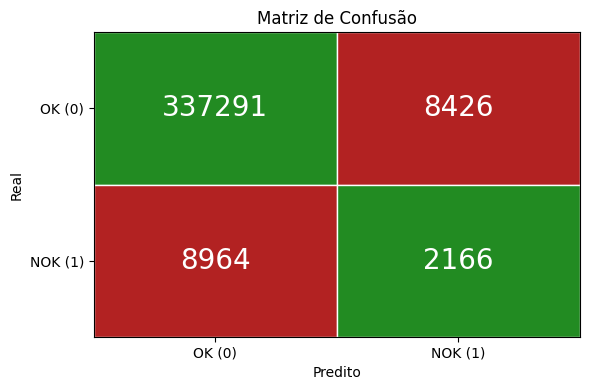

In [26]:
cm = confusion_matrix(y_test, y_pred)
labels = ["OK (0)", "NOK (1)"]

fig, ax = plt.subplots(figsize=(6, 4))

# Plotar manualmente com cores nos quadrantes
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = '#228B22' if i == j else '#B22222'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor=color, edgecolor='white', linewidth=1))
        ax.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', color='white', fontsize=20)

# Eixos e rótulos
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(labels)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
ax.set_title("Matriz de Confusão")

# Ajustes de grade
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Avaliando métricas

In [27]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df_formatted = report_df.head(3).map(lambda x: f"{x * 100:.2f}")
print(report_df_formatted)

         precision recall f1-score
0            97.41  97.56    97.49
1            20.45  19.46    19.94
accuracy     95.13  95.13    95.13


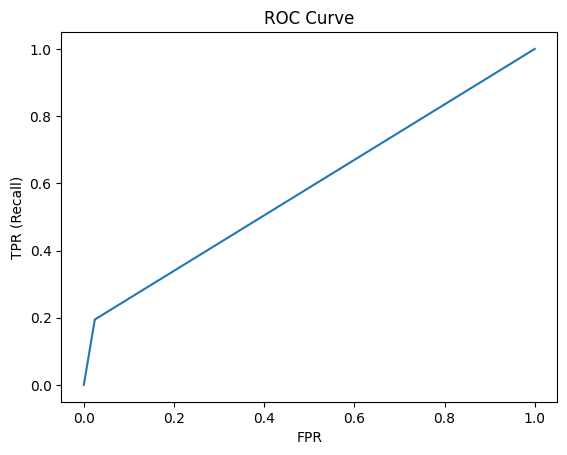

AUC: 0.59


In [17]:
y_proba = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("ROC Curve")
plt.show()
print(f"AUC: {auc:.2f}")


Pela curva ROC observamos:
1. Curva muito próxima da diagonal de aleatoriedade o que mostra não descriminar valores
2. Valor AUC maior que o de aleatoriedade (0,50) mas muito próximo disso.

# Otimizar resultado a partir da curva ROC

## Otimização F1-score

In [28]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_threshold_f1 = thresholds_pr[np.argmax(f1)]

print(f"Threshold ideal (F1-score máximo): {optimal_threshold_f1:.4f}")

Threshold ideal (F1-score máximo): 0.9688


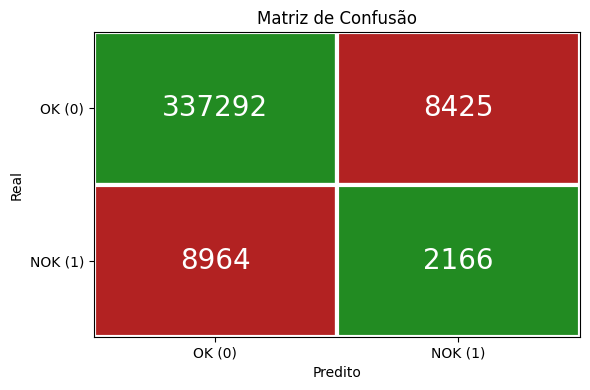

In [29]:
y_pred = (y_proba >= optimal_threshold_f1).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ["OK (0)", "NOK (1)"]

fig, ax = plt.subplots(figsize=(6, 4))

# Plotar manualmente com cores nos quadrantes
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = '#228B22' if i == j else '#B22222'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor=color, edgecolor='white', linewidth=3))
        ax.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', color='white', fontsize=20)

# Eixos e rótulos
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(labels)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
ax.set_title("Matriz de Confusão")

# Ajustes de grade
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [30]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df_formatted = report_df.head(3).map(lambda x: f"{x * 100:.2f}")
print(report_df_formatted)

         precision recall f1-score
0            97.41  97.56    97.49
1            20.45  19.46    19.94
accuracy     95.13  95.13    95.13


1. Pelo baixo valor de AUC tem um enviesamento muito grande que até mesmo alterando o ponto de marcação os resultados são similar

## Otimização Youden

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]

print(f"Threshold ideal (Youden): {optimal_threshold:.4f}")


Threshold ideal (Youden): 0.9688


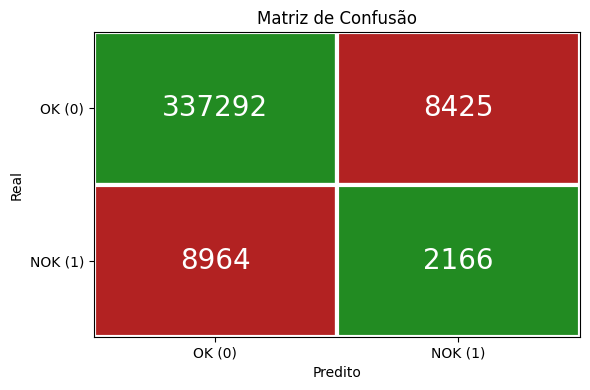

In [23]:
y_pred = (y_proba >= optimal_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ["OK (0)", "NOK (1)"]

fig, ax = plt.subplots(figsize=(6, 4))

# Plotar manualmente com cores nos quadrantes
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = '#228B22' if i == j else '#B22222'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor=color, edgecolor='white', linewidth=3))
        ax.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', color='white', fontsize=20)

# Eixos e rótulos
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(labels)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
ax.set_title("Matriz de Confusão")

# Ajustes de grade
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [24]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df_formatted = report_df.head(3).map(lambda x: f"{x * 100:.2f}")
print(report_df_formatted)

         precision recall f1-score
0            97.41  97.56    97.49
1            20.45  19.46    19.94
accuracy     95.13  95.13    95.13


1. Pelo baixo valor de AUC tem um enviesamento muito grande que até mesmo alterando o ponto de marcação os resultados são similar